## Importing necessary packages

In [1]:
# !git clone https://github.com/talhahascelik/python_stepwiseSelection

In [2]:
#!pip install corextopic
import re
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
from statistics import *
import scipy.sparse as ss
import scipy.stats as stats
import matplotlib.pyplot as plt
from IPython.display import HTML
from nltk.corpus import stopwords
from corextopic import corextopic as ct
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to C:\Users\Pras
[nltk_data]     Vengs\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# Declaring Lemmatization object for data pre-processing 
WNL = nltk.WordNetLemmatizer()

# Importing data
df = pd.read_excel("Illinois Hospital Tweets.xlsx", sheet_name="Unique Tweets")
df.head()

,id,conversation_id,created_at,date,Day,Weekday/Weekend,time,12hr format,Timestamp,Timestamp Category,...,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,Followers,Duration,Bucket,Geographical Area
0,1247547267780940032,1247547267780940032,2020-04-07 15:30:21 UTC,2020-04-07,Tuesday,Weekday,15:30:21,03:30:21 PM,0.50,AFTERNOON,...,NaN,[],NaN,NaN,NaN,NaN,4021,4195,Hospital Promotion,Rural
1,1224497930859687936,1224497930859687936,2020-02-04 01:00:31 UTC,2020-02-04,Tuesday,Weekday,01:00:31,01:00:31 AM,0.00,NIGHT,...,NaN,[],NaN,NaN,NaN,NaN,4021,4195,Health Education/Awareness,Rural
2,1255859924686574080,1255859924686574080,2020-04-30 14:01:53 UTC,2020-04-30,Thursday,Weekday,14:01:53,02:01:53 PM,0.50,AFTERNOON,...,NaN,[],NaN,NaN,NaN,NaN,4021,4195,Job Posting/Hiring,Rural
3,1261022636634767104,1261022072869773056,2020-05-14 19:56:39 UTC,2020-05-14,Thursday,Weekday,19:56:39,07:56:39 PM,0.75,EVENING,...,NaN,"[{'screen_name': 'pavangk17', 'name': 'pavangk...",NaN,NaN,NaN,NaN,4021,4195,General covid awareness,Rural
4,1243900897379433984,1243900897379433984,2020-03-28 14:00:59 UTC,2020-03-28,Saturday,Weekend,14:00:59,02:00:59 PM,0.50,AFTERNOON,...,NaN,[],NaN,NaN,NaN,NaN,4021,4195,Hospital Promotion,Rural


## <br><br>Data Pre-processing

In [4]:
# Function to remove emojis rom tweets
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

# Data pre-processing Function
def data_preprocessing(tweets_list):
    
    for i in range(len(tweets_list)):
        # Remove emojis
        tweets_list[i] = remove_emoji(tweets_list[i])
        
        # Remove URL
        tweets_list[i] = re.sub(r"http\S+", "", tweets_list[i])
        
        # Remove @user_mentions
        tweets_list[i] = re.sub(r"@\S+", "",tweets_list[i])
        
        # Converting tweets to lowercase
        tweets_list[i] = tweets_list[i].lower()
        
        # Removing punctuations from tweets
        tweets_list[i] = re.sub(r'[^\w\s]', ' ', tweets_list[i])
        
        # Splitting tweet into individual words
        tweets_list[i] = tweets_list[i].split()
        
        # Removing stop words
        tweets_list[i] = [word for word in tweets_list[i] if word not in stopwords.words('english')]
        
        # Performing lemmatization for each word and combining individual words back into a single tweet
        tweets_list[i] = " ".join([WNL.lemmatize(word) for word in tweets_list[i]])
                                  
    return tweets_list

In [5]:
# Original Tweets
tweets_list = list(df['tweet'])
prior = tweets_list[760]
tweets_list = data_preprocessing(tweets_list)
print(f'Before processing:\n{prior}\n\nAfter Processing:\n{tweets_list[760]}')

Before processing:
Safety first! 👀 Masks, hand sanitizer...thanks to the @Cubs for setting an example on and off the field.👏  https://t.co/sReulNWcNM

After Processing:
safety first mask hand sanitizer thanks setting example field


## <br><br> Unsupervised: Topic modelling using CorEx

In [6]:
# Converting the data into a sparse matrix
vectorizer = CountVectorizer(stop_words='english', max_features=None, binary=True, ngram_range=(1,2))
doc_word = vectorizer.fit_transform(tweets_list)
doc_word = ss.csr_matrix(doc_word)

doc_word.shape # n_docs x m_words

(11061, 109783)

The <b>doc_word</b> matrix comprises of 11061 rows (each representing an individual tweet) and 109783 columns (each representing a unigram/bigram from the corpus) <br><br>

The number of columns in <b>doc_word</b> matrix can further be reduced if we remove the numbers

In [7]:
# Fetching the list of words
words = list(np.asarray(vectorizer.get_feature_names()))

# Extracting only words and ignoring the digits (numbers)
words = [word for ind,word in enumerate(words) if not word.isdigit()]

# Extracting the indices only for words and ignoring the digits
not_digit_inds = [ind for ind,word in enumerate(words) if not word.isdigit()]

# Subsetting the matrix based on the above indices extracted 
doc_word = doc_word[:,not_digit_inds]

doc_word.shape

(11061, 109263)

The number of words (columns) after ignoring all the numbers has now reduced to 109263<br><br>

In [8]:
# Training the corex model with 10 topics
topic_model = ct.Corex(n_hidden=10, words=words, max_iter=200, verbose=False, seed=1)
topic_model.fit(doc_word, words=words)

In [9]:
# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: meiner,megan wright,certification obstetric,use service,rademaker,hosted,washington street,bushue achieve,board commissioner,sticking food
1: elli experience,ranked mask,vehicle arrive,sunday try,sunlight funk,privacy,ranking hospital,elizabeth pieroth,sunny mesa,wellness visit
2: ago tip,care child,ago remains,apply donor,8pm est,mask evidence,visitor week,service currently,supporting patient,column qc
3: curve meet,cut oven,carmen rosario,air pollution,hope resolve,box hanging,superbowl2020,provide limited,precaution minimize,hope promise
4: rooney md,heart goredforwomen,website rush,image printable,image provided,heart happen,website subscribe,1000 checking,hoffmanestates award,receive professional
5: megan defrates,hosting shoe,herb flower,carle_docs,activity safely,thing hand,emerald,emerald circle,air advocate,year bachelor
6: cardinal,attends carle,distancing webinar,robot deployed,inpatient exception,inpatient child,create culture,raise hand,care constantly,dan olivett
7: sc

In [10]:
print(f'Total correlation = {round(topic_model.tc,4)}')

Total correlation = 23.699


## <br><br> Semi-supervised: Anchored CorEx

In [11]:
anchor_words = [
    #0 Job Posting/Hiring
    ["experience", "position", "hire", "looking", "certified", "looking hire", "join team", "service looking", "extensive onsite", 
     "onsite service", "food service", "certification"],
    
    #1 Hospital Promotion
    ["provide", "offer", "service", "partner", "surgeon", "medical center", "family medicine", "health foundation",
     "minimally invasive", "high quality", "visit website", "general surgery", "appointment", "medical group", "care wondering",
     "immediate care", "state art", "primary care", "health center", "robotic surgery", "board certified", "advancement"],
    
    #2 Health Education/Awareness
    ["cancer", "heart", "awareness", "screening", "blog", "exercise", "heart disease", "awareness month", "colon cancer", 
     "mental health", "reduce risk", "colorectal cancer", "cancer awareness", "heart health", "blood pressure", "heart attack"],
    
    #3 Award/Achievement/Appreciation
    ["thank", "appreciation", "congratulation", "award", "recognition", "frontline", "help ensure", "care patient",
     "assessment program", "hospital assessment", "medicaid program", "access quality", "quality hospital", "thank support",
     "award", "big thank", "community thank", "thank sharing", "thank nurse", "thank staff", 
     "thank supporting", "staff thank", "thanks appreciation"],
    
    #4 Event 
    ["register", "event", "join", "discussion", "schedule", "donate", "donation", "cancer screening", "blood drive", 
     "time register", "info register", "free virtual", "invite join", "panel", "blood donation",  "question using", 
     "panel discussion",  "twitter chat", "live", "cancer management", "advancement cancer", "flu shot","mobile health",
     "residency program", "registration"],
    
    #5 Covid specific event
    ["testing", "clinic", "symptomatic", "non symptomatic", "interested tested", "care connect"],
    
    #6 General covid awareness
    ["cdc", "mask", "hand", "wash", "guideline", "stay home", "wear mask", "wash hand", "social distancing", "spread covid", 
     "mask public", "social distance", "face covering", "wearing mask", "reduce spread", "cloth face", "ventilator"], 
    
    #7 Hospital specific covid education
    ["doctor", "dr", "expert", "help", "ask", "infection","askdrmarkman", "chief medical", "medical officer", "president ceo", 
     "vp chief", "answer question", "disease expert", "offer tip", "officer dr", "staff sharing", "expert say", "answered"],
    
    #8 Covid Policy Changes/hospital changes
    ["visitor", "hotline", "policy","screening", "patient visitor", "visitor guideline", "new visitor", "visitor restriction", 
     "visitor policy", "safety patient", "health safety", "visitor staff", "virtual solution"],
    
    #9 Miscellaneous
    ["census", "dissatisfaction", "valentinesday", "superbowl", "football", "new year", "happynewyear", "experienced patient", 
     "patient relation", "happy birthday", "relation team", "apologize dissatisfaction", "feedback welcome", "patient relation"]
]

In [12]:
# Fitting the model to the doc_word matrix
anchored_topic_model = ct.Corex(n_hidden=10, seed=1)
anchored_topic_model.fit(doc_word, words=words, anchors=anchor_words, anchor_strength=8)

In [13]:
# Getting the top seven words in each topic
topics = anchored_topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words[:7]))

0: extensive onsite,position,certification,join team,looking hire,food service,certified
1: care wondering,healthcare caring,provide,medical center,robotic surgery,immediate care,carle_docs
2: blood pressure,heart health,screening,colorectal cancer,heart attack,cancer awareness,awareness
3: thank staff,appreciation,thank nurse,award,care patient,help ensure,thank
4: discussion,megan wright,completed fall,meiner,flu shot,time register,crate
5: symptomatic,non symptomatic,clinic,interested tested,care connect,care eye,zvi
6: room main,rooney md,healthy relationship,wearing mask,social distancing,social distance,teen facing
7: dr,expert,chief medical,answered,officer dr,askdrmarkman,disease expert
8: screening,visitor policy,safety patient,visitor staff,policy,new visitor,health safety
9: census,relation team,football,experienced patient,apologize dissatisfaction,patient relation,happynewyear


In [14]:
# List to store the topics of each tweet
bucket_list = []

# Dictionary to convert number into topic defined by us
num_to_bucket = {0:"Job Posting/Hiring", 1:"Hospital Promotion", 2:"Health Education/Awareness",
                 3:"Award/Achievement/Appreciation", 4:"Event", 5:"Covid specific event",
                 6:"General covid awareness", 7:"Hospital specific covid education", 8:"Covid Policy Changes/hospital changes", 
                 9:"Miscellaneous"}

# Using z-scores to predict the topic for each tweet
for i in range(anchored_topic_model.labels.shape[0]):
    logz_list = list(anchored_topic_model.log_z[i])
    indx = logz_list.index(max(logz_list))
    bucket_list.append(num_to_bucket[indx])
    
# Adding the Topic list as a column in the dataframe
df["Topic"] = bucket_list

In [15]:
# Total correlation of the anchored corex model
anchored_topic_model.tc

63.83320452884636

The topics segregated based on the provided anchor words now are in line with the topics defined by us. Also, the overall correlation of the semi-supervised model has doubled compared to unsupervised model indicating the words grouped together under the topics are more correlated (make better sense)

# <br><br><center>HYPOTHESIS TESTING</center>

In [16]:
df = df[["id", "created_at", "Weekday/Weekend", "Timestamp Category", "username", "name", "tweet", "Followers", "Duration",
         "Topic", "Geographical Area", "video", "likes_count", "retweets_count"]]

df = df.rename(columns={"id":'Tweet ID', 'created_at':'Created at', 'Weekday/Weekend':'Day', 'Timestamp Category':'Time of day',
                        'username':'Handle Name', 'name':'Hospital', 'tweet':'Tweet', 'Followers':'Number of Followers',
                        'Duration':'Days since account creation', 'video':'Media', 'likes_count':'Likes', 
                        'retweets_count':'Retweets'})
df.head()

,Tweet ID,Created at,Day,Time of day,Handle Name,Hospital,Tweet,Number of Followers,Days since account creation,Topic,Geographical Area,Media,Likes,Retweets
0,1247547267780940032,2020-04-07 15:30:21 UTC,Weekday,AFTERNOON,amitahealth,AMITA Health,"When it comes to global health, we're all in i...",4021,4195,Hospital Promotion,Rural,1,3,1
1,1224497930859687936,2020-02-04 01:00:31 UTC,Weekday,NIGHT,amitahealth,AMITA Health,Leap forward with us at the Inaugural #AMITAhe...,4021,4195,Health Education/Awareness,Rural,1,1,1
2,1255859924686574080,2020-04-30 14:01:53 UTC,Weekday,AFTERNOON,amitahealth,AMITA Health,If you have tested positive for COVID-19 and r...,4021,4195,Job Posting/Hiring,Rural,1,3,1
3,1261022636634767104,2020-05-14 19:56:39 UTC,Weekday,EVENING,amitahealth,AMITA Health,@pavangk17 Thank you for bringing to our atten...,4021,4195,General covid awareness,Rural,0,1,2
4,1243900897379433984,2020-03-28 14:00:59 UTC,Weekend,AFTERNOON,amitahealth,AMITA Health,Stay informed! Check the link below for the la...,4021,4195,Hospital Promotion,Rural,0,1,0


In [17]:
df = pd.read_excel("Illinois Hospital Tweets.xlsx", "Illinois Hospital Tweets")
df.head()

,Tweet ID,Created at,Day,Time of day,Handle Name,Hospital,Tweet,Number of Followers,Days since account creation,Topic,Geographical Area,Media,Likes,Retweets
0,1247547267780940032,2020-04-07 15:30:21 UTC,Weekday,AFTERNOON,amitahealth,AMITA Health,"When it comes to global health, we're all in i...",4021,4195,Hospital Promotion,Rural,1,3,1
1,1224497930859687936,2020-02-04 01:00:31 UTC,Weekday,NIGHT,amitahealth,AMITA Health,Leap forward with us at the Inaugural #AMITAhe...,4021,4195,Health Education/Awareness,Rural,1,1,1
2,1255859924686574080,2020-04-30 14:01:53 UTC,Weekday,AFTERNOON,amitahealth,AMITA Health,If you have tested positive for COVID-19 and r...,4021,4195,Job Posting/Hiring,Rural,1,3,1
3,1261022636634767104,2020-05-14 19:56:39 UTC,Weekday,EVENING,amitahealth,AMITA Health,@pavangk17 Thank you for bringing to our atten...,4021,4195,General covid awareness,Rural,0,1,2
4,1243900897379433984,2020-03-28 14:00:59 UTC,Weekend,AFTERNOON,amitahealth,AMITA Health,Stay informed! Check the link below for the la...,4021,4195,Hospital Promotion,Rural,0,1,0


## <br><font color="orange">T-test</font>

### Day

In [18]:
wkday = df[df["Day"]=="Weekday"]
wkend = df[df["Day"]=="Weekend"]

In [19]:
stats.ttest_ind(wkday['Likes'], wkend['Likes'])

Ttest_indResult(statistic=-0.6299689666187421, pvalue=0.5287279037602568)

In [20]:
stats.ttest_ind(wkday['Retweets'], wkend['Retweets'])

Ttest_indResult(statistic=0.03433938695291021, pvalue=0.9726071368686582)

The p-value of the is greater than 0.05 for both likes and re-tweets. Hence we can confirm that there is <b><font color = "red">no statistical difference </font></b>in the number of likes and retweets a tweet receives based on when tweet was tweeted, <b><font color = "blue">weekend</font></b> (or) <b><font color = "blue">weekday</font></b>

### Geographical Area

In [21]:
rural = df[df["Geographical Area"]=="Rural"]
urban = df[df["Geographical Area"]=="Urban"]

In [22]:
stats.ttest_ind(rural['Likes'], rural['Likes'])

Ttest_indResult(statistic=0.0, pvalue=1.0)

In [23]:
stats.ttest_ind(urban['Retweets'], urban['Retweets'])

Ttest_indResult(statistic=0.0, pvalue=1.0)

The p-value of the is greater than 0.05 for both likes and re-tweets. Hence we can confirm that there is <b><font color = "red">no statistical difference </font></b>in the number of likes and retweets a tweet receives based on the geographical location of the hospital, <b><font color = "blue">rural</font></b> (or) <b><font color = "blue">urban</font></b>

### Media

In [24]:
media_yes = df[df["Media"]==1]
media_no = df[df["Media"]==0]

In [25]:
stats.ttest_ind(media_yes['Likes'], media_no['Likes'])

Ttest_indResult(statistic=7.828500833758397, pvalue=5.387807961263879e-15)

In [26]:
stats.ttest_ind(media_yes['Retweets'], media_no['Retweets'])

Ttest_indResult(statistic=5.991468771923947, pvalue=2.1443106754853373e-09)

The p-value of the is lower than 0.05 for both likes and re-tweets. Hence we can confirm that there is a <b><font color = "lime">statistical difference </font></b>in the number of likes and retweets a tweet receives based on whether the tweet <b><font color = "blue">includes an  image/video</font></b> (or) <b><font color = "blue">not</font></b>

## <br><font color="orange">ANOVA</font>

### Time of day

In [27]:
morn = df[df["Time of day"] == "MORNING"]
aftr = df[df["Time of day"] == "AFTERNOON"]
even = df[df["Time of day"] == "EVENING"]
night = df[df["Time of day"] == "NIGHT"]

In [28]:
stats.f_oneway(morn['Likes'], aftr['Likes'], even['Likes'], night['Likes'])

F_onewayResult(statistic=0.24987507718981497, pvalue=0.861472053180381)

In [29]:
stats.f_oneway(morn['Retweets'], aftr['Retweets'], even['Retweets'], night['Retweets'])

F_onewayResult(statistic=0.4739549654642143, pvalue=0.7004239146200343)

The p-value of the is greater than 0.05 for both likes and re-tweets. Hence we can confirm that there is <b><font color = "red">no statistical difference </font></b>in the number of likes and retweets a tweet receives based on the time of day it was tweeted, <b><font color = "blue">Morning, Afternoon, Evening</font></b> (or) <b><font color = "blue">weekday</font></b>

### Topic

In [30]:
topic_1 = df[df["Topic"] == 'Hospital Promotion']
topic_2 = df[df["Topic"] == 'Health Education/Awareness']
topic_3 = df[df["Topic"] == 'Job Posting/Hiring']
topic_4 = df[df["Topic"] == 'General covid awareness']
topic_5 = df[df["Topic"] == 'Hospital specific covid education']
topic_6 = df[df["Topic"] == 'Covid Policy Changes/hospital changes']
topic_7 = df[df["Topic"] == 'Award/Achievement/Appreciation']
topic_8 = df[df["Topic"] == 'Covid specific event']
topic_9 = df[df["Topic"] == 'Miscellaneous']
topic_10 = df[df["Topic"] == 'Event']

In [31]:
stats.f_oneway(topic_1['Likes'], topic_2['Likes'], topic_3['Likes'], topic_4['Likes'], topic_5['Likes'], 
               topic_6['Likes'], topic_7['Likes'], topic_8['Likes'], topic_9['Likes'], topic_10['Likes'])

F_onewayResult(statistic=7.472806839621658, pvalue=5.692677789523296e-11)

In [32]:
stats.f_oneway(topic_1['Retweets'], topic_2['Retweets'], topic_3['Retweets'], topic_4['Retweets'], topic_5['Retweets'], 
               topic_6['Retweets'], topic_7['Retweets'], topic_8['Retweets'], topic_9['Retweets'], topic_10['Retweets'])

F_onewayResult(statistic=4.29592534350941, pvalue=1.3554181144365027e-05)

The p-value of the is lower than 0.05 for both likes and re-tweets. Hence we can confirm that there is a <b><font color = "lime">statistical difference </font></b>in the number of likes and retweets a tweet receives based on the <b><font color = "blue">tweet topic</font></b>

In [33]:
import xlsxwriter
writer = pd.ExcelWriter('Hypothesis Testing.xlsx', engine='xlsxwriter')

list_of_topics = [topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10]

list_of_topics_dict = {0: "Hospital Promotion", 1: "Health Education/Awareness", 2:"Job Posting/Hiring",
                       3:"General covid awareness", 4:"Hospital specific covid education",
                       5:"Covid Policy Changes/hospital change", 6:"Award/Achievement/Appreciation", 7:"Covid specific event",
                       8:"Miscellaneous", 9:"Event"}
topic_1_list = []
topic_2_list = []
test_val = []
for i in range(10):
    for j in range(10):
        test_val.append(round(stats.ttest_ind(list_of_topics[i]['Retweets'] , list_of_topics[j]['Retweets'])[1], 3))
        topic_1_list.append(list_of_topics_dict[i])
        topic_2_list.append(list_of_topics_dict[j])
        
df2 = pd.DataFrame({"Topic 1":topic_1_list, "Topic 2":topic_2_list, "T-test: p-value":test_val})
df2.to_excel(writer, sheet_name="Topics - Retweets", index=False)

writer.save()

## <br><font color="orange"> Pearson Correlation

### Days since account creation

In [34]:
stats.pearsonr(df["Days since account creation"], df["Likes"])

(0.08250258967285552, 3.600817885774504e-18)

In [35]:
stats.pearsonr(df["Days since account creation"], df["Retweets"])

(0.06844305853525985, 5.766945942059395e-13)

The p-value of the is lower than 0.05 for both likes and re-tweets. Hence we can confirm that there is a <b><font color = "lime">statistical difference </font></b>in the number of likes and retweets a tweet receives based on the <b><font color = "blue">number of days since twiiter account has been created</font></b>

### Number of Followers

In [36]:
stats.pearsonr(df["Number of Followers"], df["Likes"])

(0.17307881041877538, 4.009769206593016e-75)

In [37]:
stats.pearsonr(df["Number of Followers"], df["Retweets"])

(0.14699847943670993, 1.781081978913164e-54)

The p-value of the is lower than 0.05 for both likes and re-tweets. Hence we can confirm that there is a <b><font color = "lime">statistical difference </font></b>in the number of likes and retweets a tweet receives based on whether the tweet <b><font color = "blue">number of followers</font></b> for the twitter account

# <br><br><center>LINEAR REGRESSION</center>

In [38]:
from sklearn import metrics
import statsmodels.api as sm
import stepwiseSelection as ss
import sklearn.feature_selection
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor 

In [39]:
lm = LinearRegression()

## Data Processing

In [40]:
#Choosing only required Columns
regression_df = df[['Number of Followers', 'Days since account creation', 'Day', 'Time of day','Geographical Area','Media', 'Topic','Likes', 'Retweets']]

#Replacing 1's & 0's of "Media" column with strings
regression_df['Media'].loc[(regression_df['Media'] == 1)] = "Contains Image/Video"
regression_df['Media'].loc[(regression_df['Media'] == 0)] = "No Image/Video"

# Performing one hot coding of categorical column
for col_name in ["Day","Time of day","Geographical Area","Media","Topic"]:
    regression_df = pd.concat([pd.get_dummies(regression_df[col_name]), regression_df], axis=1)

# Selecting the required columns in the required order
regression_df = regression_df.drop(["Day","Time of day","Geographical Area","Media","Topic"], axis=1)
regression_df = pd.concat([regression_df.iloc[:,[20,21]] , regression_df.iloc[:,[*range(20)]] , regression_df.iloc[:,[-2, -1]]], axis=1)

regression_df.head()

################################################################################################################################################################################
# regression_df = pd.read_excel("Illinois Hospital Tweets.xlsx", "Illinois Hospital Tweets")
# regression_df = regression_df[['Number of Followers', 'Days since account creation', 'Day', 'Time of day',
#                                'Geographical Area','Media', 'Topic','Likes', 'Retweets']]

# regression_df['Media'].loc[(regression_df['Media'] == 1)] = "Contains Image/Video"
# regression_df['Media'].loc[(regression_df['Media'] == 0)] = "No Image/Video"

# for col_name in ["Day","Time of day","Geographical Area","Media","Topic"]:
#     regression_df = pd.concat([pd.get_dummies(regression_df[col_name]), regression_df], axis=1)
    
# regression_df = regression_df.drop(["Day","Time of day","Geographical Area","Media","Topic"], axis=1)
# regression_df = pd.concat([regression_df.iloc[:,[20,21]] , regression_df.iloc[:,[*range(20)]] , regression_df.iloc[:,[-2, -1]]], axis=1)
# regression_df.head()

C:\Users\Pras Vengs\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Pras Vengs\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\Pras Vengs\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Number of Followers,Days since account creation,Award/Achievement/Appreciation,Covid Policy Changes/hospital changes,Covid specific event,Event,General covid awareness,Health Education/Awareness,Hospital Promotion,Hospital specific covid education,...,Rural,Urban,AFTERNOON,EVENING,MORNING,NIGHT,Weekday,Weekend,Likes,Retweets
0,4021,4195,0,0,0,0,0,0,1,0,...,1,0,1,0,0,0,1,0,3,1
1,4021,4195,0,0,0,0,0,1,0,0,...,1,0,0,0,0,1,1,0,1,1
2,4021,4195,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,1,0,3,1
3,4021,4195,0,0,0,0,1,0,0,0,...,1,0,0,1,0,0,1,0,1,2
4,4021,4195,0,0,0,0,0,0,1,0,...,1,0,1,0,0,0,0,1,1,0


In [41]:
# Checking the range of values in "Days since account creation" & "Number of Followers" column
print(f'Range of values in both the numerical columns\n\nDays since account creation:\tMin = {regression_df["Days since account creation"].min()}\tMax = {regression_df["Days since account creation"].max()}\nNumber of Followers:\t\tMin = {regression_df["Number of Followers"].min()}\t\tMax = {regression_df["Number of Followers"].max()}')

Range of values in both the numerical columns

Days since account creation:	Min = 443	Max = 4418
Number of Followers:		Min = 3		Max = 27700


Due to a high range of values in both the columns, normalizing the values under both of them

In [42]:
# Selecting both numerical columns
x = regression_df[["Days since account creation" , "Number of Followers"]]

# Normalizing both the columns
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)

# Concatenating the normalized values with original dataframe
regression_df["Days since account creation"] = list(np.array(x_scaled).transpose()[0])
regression_df["Number of Followers"] = list(np.array(x_scaled).transpose()[1])

regression_df = regression_df.reset_index(drop=True)

# Final DataFrame
regression_df.head()

,Number of Followers,Days since account creation,Award/Achievement/Appreciation,Covid Policy Changes/hospital changes,Covid specific event,Event,General covid awareness,Health Education/Awareness,Hospital Promotion,Hospital specific covid education,...,Rural,Urban,AFTERNOON,EVENING,MORNING,NIGHT,Weekday,Weekend,Likes,Retweets
0,0.14507,0.943899,0,0,0,0,0,0,1,0,...,1,0,1,0,0,0,1,0,3,1
1,0.14507,0.943899,0,0,0,0,0,1,0,0,...,1,0,0,0,0,1,1,0,1,1
2,0.14507,0.943899,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,1,0,3,1
3,0.14507,0.943899,0,0,0,0,1,0,0,0,...,1,0,0,1,0,0,1,0,1,2
4,0.14507,0.943899,0,0,0,0,0,0,1,0,...,1,0,1,0,0,0,0,1,1,0


## Feature Selection - Stepwise regression

In [43]:
# Stepwise regression for likes
X = regression_df.drop(["Likes", "Retweets"], axis=1)
y = regression_df.Likes
final_vars, iterations_logs = ss.backwardSelection(X,y, model_type="linear")

Character Variables (Dummies Generated, First Dummies Dropped): []
Eliminated : Job Posting/Hiring
Regained :  Job Posting/Hiring
                            OLS Regression Results                            
Dep. Variable:                  Likes   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     42.01
Date:                Wed, 09 Dec 2020   Prob (F-statistic):          3.48e-136
Time:                        17:12:10   Log-Likelihood:                -46526.
No. Observations:               11061   AIC:                         9.309e+04
Df Residuals:                   11043   BIC:                         9.322e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t

In [44]:
# Stepwise regression for Retweets
X = regression_df.drop(["Likes", "Retweets"], axis=1)
y = regression_df.Retweets
final_vars, iterations_logs = ss.backwardSelection(X,y, model_type="linear")

Character Variables (Dummies Generated, First Dummies Dropped): []
Eliminated : Covid specific event
Eliminated : MORNING
Eliminated : No Image/Video
Eliminated : Event
Eliminated : Days since account creation
Eliminated : Health Education/Awareness
Eliminated : AFTERNOON
Eliminated : EVENING
Eliminated : NIGHT
Eliminated : General covid awareness
                            OLS Regression Results                            
Dep. Variable:               Retweets   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     53.06
Date:                Wed, 09 Dec 2020   Prob (F-statistic):          5.07e-105
Time:                        17:12:10   Log-Likelihood:                -33673.
No. Observations:               11061   AIC:                         6.737e+04
Df Residuals:                   11050   BIC:                         6.745e+04
Df Model:         

## <br><br><br><br>Feature Selection - VIF (Variance Inflation Factor)
<font size=4>Using <b>VIF</b> the significant variables are slected as below:</font><br>                  
 [1] Number of Followers                  
 [2] Days since account creation          
 [3] Covid Policy Changes/hospital changes                  
 [4] Covid specific event                 
 [5] Event                                
 [6] General covid awareness              
 [7] Health Education/Awareness           
 [8] Hospital specific covid education    
 [9] Job Posting Hiring                   
[10] Miscellaneous                        
[11] No Image/Video                       
[12] Urban                                
[13] EVENING                              
[14] MORNING                              
[15] NIGHT                                
[16] Weekend<br><br>

## <br>Feature Selection - Correlation matrix

<function matplotlib.pyplot.show(*args, **kw)>

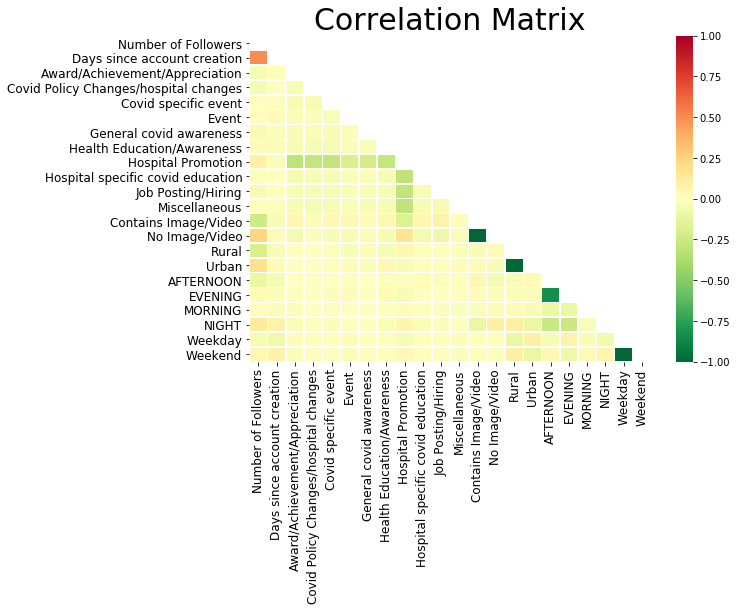

In [45]:
#Correlation Matrix
corr_df = regression_df.iloc[:, :-2].corr(method = 'pearson')
mask = np.zeros_like(corr_df)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(9,6))
sns.heatmap(corr_df, cmap = 'RdYlGn_r', vmax = 1.0, vmin = -1.0, 
                mask = mask, linewidths = 0.5)
plt.title("Correlation Matrix", fontsize=30)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.show

<font size=4><br><br>Based on the above analysis we can choose the following variables to predict
<br><br><b><font color="blue">Likes</font></b>:<br></font>
 [1] Number of Followers                  
 [2] Days since account creation          
 [3] Covid Policy Changes/hospital changes                  
 [4] Covid specific event                 
 [5] Event                                
 [6] General covid awareness              
 [7] Health Education/Awareness           
 [8] Hospital specific covid education           
 [9] Miscellaneous                        
[10] Contains Image/Video                       
[11] Urban                                
[12] EVENING                              
[13] MORNING                              
[14] NIGHT                                
[15] Weekend
<br><br><b><font size=4><font color="blue">Retweets</font>:<br></font></b>
[1] Number of Followers<br>
[2] Covid Policy Changes/hospital changes<br>
[3] Hospital specific covid education<br>
[4] Job Posting Hiring<br>
[5] Miscellaneous<br>
[6] No Image/Video<br>
[7] Urban<br><br>

### Likes

In [46]:
X_train, X_test, y_train, y_test = train_test_split(regression_df.iloc[:,:-2], regression_df[["Likes"]], test_size=0.1, random_state=101)

In [47]:
cols = ["Number of Followers", "Days since account creation", "Covid Policy Changes/hospital changes", "Covid specific event",
        "Event", "General covid awareness", "Health Education/Awareness", "Hospital specific covid education", "Miscellaneous",
        "Contains Image/Video", "Urban", "EVENING", "MORNING", "NIGHT", "Weekend"]

linear_model=sm.OLS(y_train["Likes"], X_train[cols])
result=linear_model.fit()
print(result.summary2())

                           Results: Ordinary least squares
Model:                     OLS               Adj. R-squared (uncentered):  0.114     
Dependent Variable:        Likes             AIC:                          84659.1195
Date:                      2020-12-09 17:12  BIC:                          84767.2055
No. Observations:          9954              Log-Likelihood:               -42315.   
Df Model:                  15                F-statistic:                  85.99     
Df Residuals:              9939              Prob (F-statistic):           2.04e-249 
R-squared (uncentered):    0.115             Scale:                        288.78    
-------------------------------------------------------------------------------------
                                       Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
-------------------------------------------------------------------------------------
Number of Followers                    8.7649   0.5347 16.3932 0.0000  7.7168  9.

In [48]:
# Fitting training data to Linear regression model
lm.fit(X_train[cols], y_train)

# Prediction of target variable
y_hat = lm.predict(X_test[cols])

# Mean Squared Error
print(f'MSE = {round(mean_squared_error(y_test, y_hat),4)}')

MSE = 43.9518


(array([-2.,  0.,  2.,  4.,  6.,  8., 10.]),
 <a list of 7 Text yticklabel objects>)

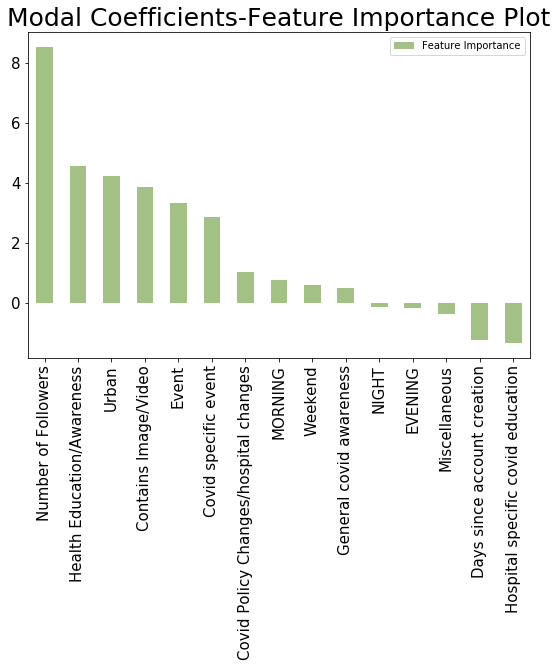

In [49]:
likes_importance = lm.coef_.tolist()[0]
coef = pd.DataFrame(likes_importance, cols, columns=["Feature Importance"]).sort_values(by=['Feature Importance'], ascending=False)

coef.plot(kind='bar', figsize=(9,6), color=(0.4, 0.6, 0.2, 0.6))
plt.title("Modal Coefficients-Feature Importance Plot", fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

### Retweets

In [50]:
regression_df.columns

Index(['Number of Followers', 'Days since account creation',
       'Award/Achievement/Appreciation',
       'Covid Policy Changes/hospital changes', 'Covid specific event',
       'Event', 'General covid awareness', 'Health Education/Awareness',
       'Hospital Promotion', 'Hospital specific covid education',
       'Job Posting/Hiring', 'Miscellaneous', 'Contains Image/Video',
       'No Image/Video', 'Rural', 'Urban', 'AFTERNOON', 'EVENING', 'MORNING',
       'NIGHT', 'Weekday', 'Weekend', 'Likes', 'Retweets'],
      dtype='object')

In [51]:
X_train, X_test, y_train, y_test = train_test_split(regression_df.iloc[:,:-2], regression_df[["Retweets"]], test_size=0.1, random_state=101)

In [52]:
cols = ["Number of Followers", "Covid Policy Changes/hospital changes", "Hospital specific covid education",
        "Job Posting/Hiring", "Miscellaneous", "No Image/Video", "Urban"]

linear_model=sm.OLS(y_train["Retweets"], X_train[cols])
result=linear_model.fit()
print(result.summary2())

                           Results: Ordinary least squares
Model:                     OLS               Adj. R-squared (uncentered):  0.093     
Dependent Variable:        Retweets          AIC:                          61490.6085
Date:                      2020-12-09 17:12  BIC:                          61541.0486
No. Observations:          9954              Log-Likelihood:               -30738.   
Df Model:                  7                 F-statistic:                  147.4     
Df Residuals:              9947              Prob (F-statistic):           9.14e-208 
R-squared (uncentered):    0.094             Scale:                        28.188    
-------------------------------------------------------------------------------------
                                       Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
-------------------------------------------------------------------------------------
Number of Followers                    2.4930   0.1335 18.6742 0.0000  2.2313  2.

In [53]:
# Fitting training data to Linear regression model
lm.fit(X_train[cols], y_train)

# Prediction of target variable
y_hat = lm.predict(X_test[cols])

# Mean Squared Error
print(f'MSE = {round(mean_squared_error(y_test, y_hat),4)}')

MSE = 6.3993


(array([-1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5]),
 <a list of 9 Text yticklabel objects>)

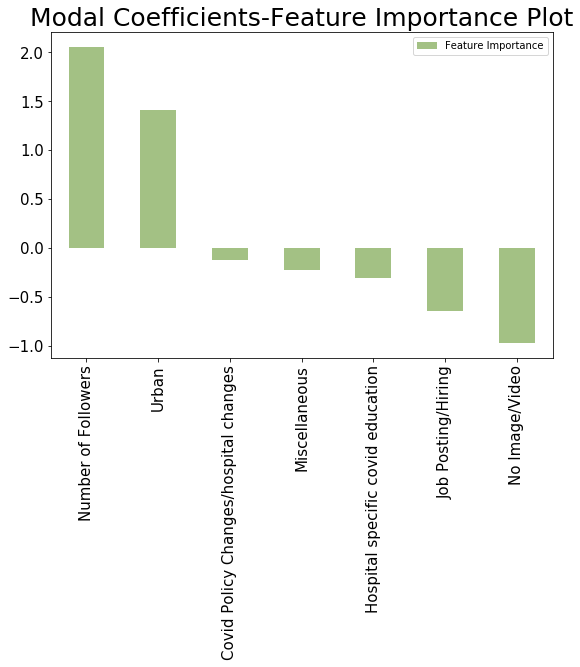

In [54]:
likes_importance = lm.coef_.tolist()[0]
coef = pd.DataFrame(likes_importance, cols, columns=["Feature Importance"]).sort_values(by=['Feature Importance'], ascending=False)

coef.plot(kind='bar', figsize=(9,6), color=(0.4, 0.6, 0.2, 0.6))
plt.title("Modal Coefficients-Feature Importance Plot", fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)